In [1]:
import torch_geometric.datasets as datasets

mutag = datasets.TUDataset(root='data', name='MUTAG')

In [2]:
from gnnexplain.nn.gcn import GraphGCN
from lightning import LightningModule

model = GraphGCN.load_from_checkpoint('checkpoints/MUTAG-epoch=99.ckpt').cpu()
isinstance(model, LightningModule)

True

In [3]:
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch

loader = DataLoader(mutag, batch_size=40000, shuffle=False)
batch = loader.__iter__().__next__().cpu()
l = batch.to_data_list()
train, test = Batch.from_data_list(l[:150]), Batch.from_data_list(l[150:])

In [4]:
(model(test).argmax(1) == test.y).float().mean()

tensor(0.7632)

In [5]:
from gnnexplain.model.gtree import *
import optuna

optuna.logging.set_verbosity(optuna.logging.WARNING)
opt = Optimizer(lmb=1e-3, max_ccp_alpha=1e-3, n_trials=100)
expl = opt.optimize(train, model)

/home/apluska/miniconda3/envs/gnnexplain/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Best trial: 73. Best value: 0.891367: 100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


In [6]:
expl.accuracy(train)

0.8533333333333334

In [7]:
expl.accuracy(test)

0.7631578947368421

TypeError: ExplainerLayer.plot() takes 2 positional arguments but 3 were given

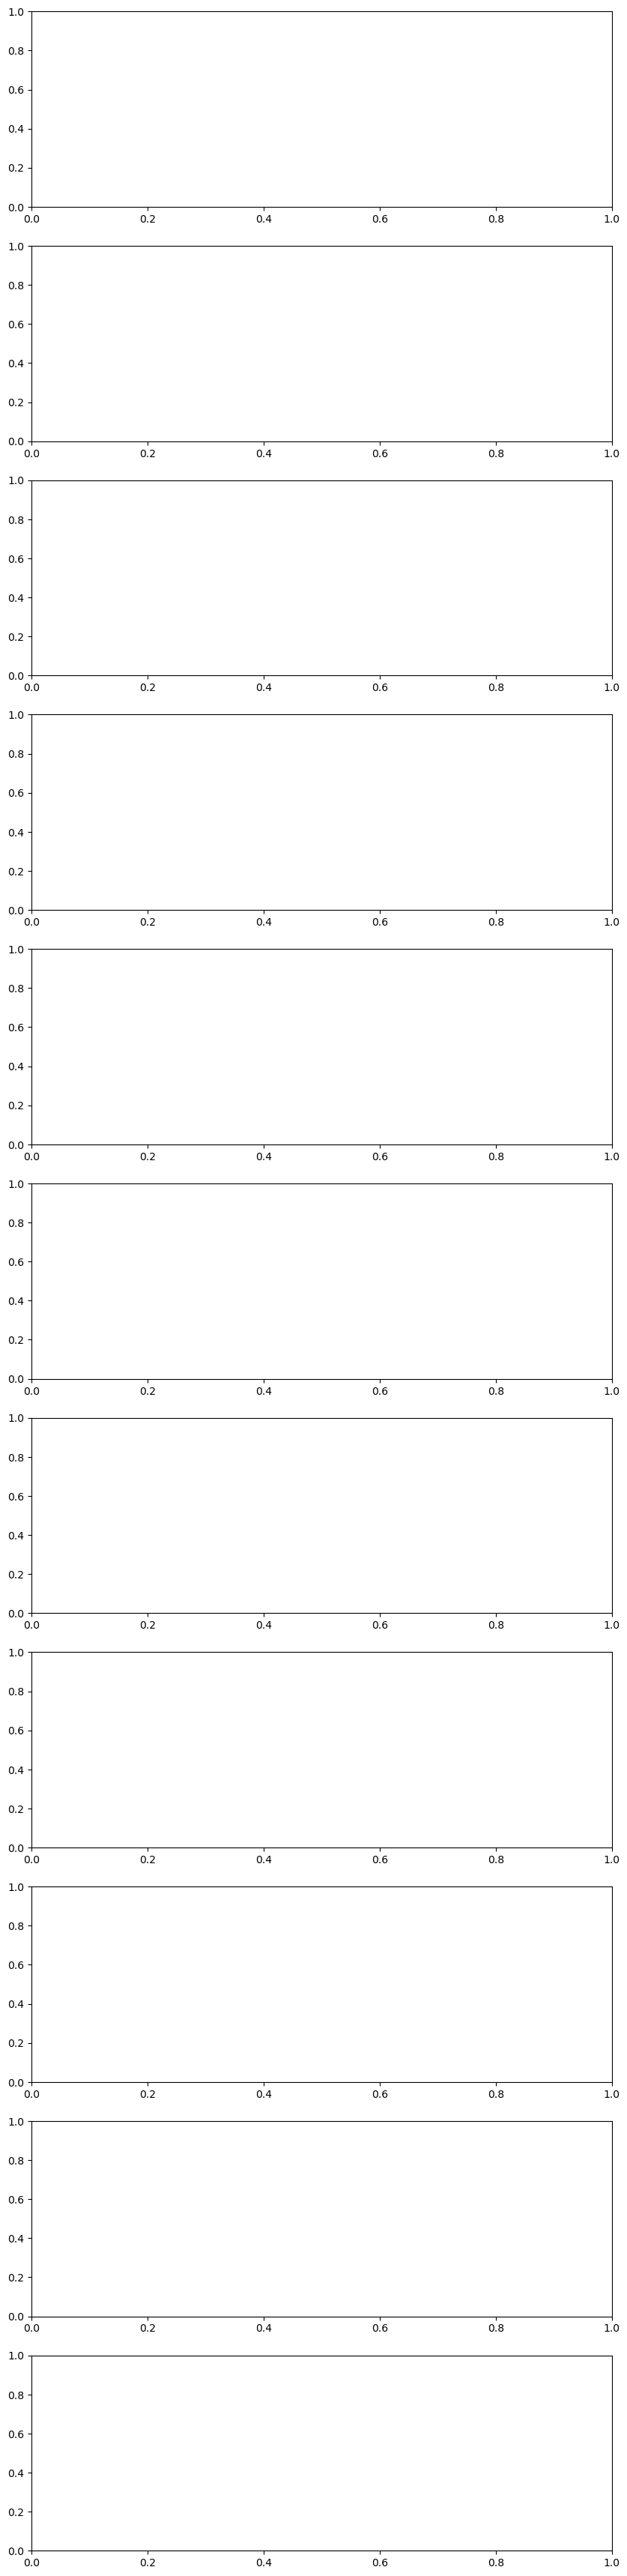

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows = len(expl.layer) + 1, figsize=(10, 4 * len(expl.layer) + 4))
for k in range(len(expl.layer)):
    expl.layer[k].plot(axs[k], k)
expl.out_layer.plot(axs[-1], k+1)
plt.savefig(f'figures/MUTAG_{expl.accuracy(test):.0%}.png')
plt.close()